# EPRL self energy

Notebook for the analysis of EPRL self energy, including tests for Monte Carlo sampler

## Setup

In [1]:
using CSV
using DataFrames
using HalfIntegers, JLD2, Distributions, Random
using LaTeXStrings

In [2]:
using Statistics
using StatsBase
using StatsPlots

In [4]:
# this allows to save images as eps using the "savefig" function, but it changes the plot style as well
# pyplot()

To save images in eps, we run *imagemagick* via shell command

In [3]:
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    grid = :true,
    gridlinewidth = 0.5,
    fontfamily="Computer Modern",
    framestyle=:box,
    size=(800,300),
    margin=5Plots.mm
)
scalefontsizes(1.3)

# Decide how many Monte Carlo samples we take

We look at $N_{mc}=100\,000$ samples. We estimate the value of the Layers averaging over 20 trials and the error with the standard deviation. Then we sum the average value of the layers and we sum variances

In [26]:
BASE_DATA_DIRECTORY = "../../data";
function get_data(Nmc, Dl, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/EPRL/immirzi_0.1/Dl_$(Dl)/weight_1.0/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end
# weight_1.0/ib_0

get_data (generic function with 1 method)

In [27]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000,10, trial).amp[id] - get_data(100000,10, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_error_Nmc100K = error_Nmc100K./amplitude_Nmc100K;


In [32]:
function get_self_energy_exact(Dl)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/EPRL/immirzi_0.1/Dl_$(Dl)/ampls_cutoff_10_ib_0.0.csv",
        ),
    )
end
exact_amplitude = get_self_energy_exact(10).amp[2:end];


relative_Nmc100K  = 100 .*(amplitude_Nmc100K ./exact_amplitude .-1);
error_relative_Nmc100K = 100 .* error_Nmc100K ./exact_amplitude;


plot2 = Plot{Plots.GRBackend() n=1}


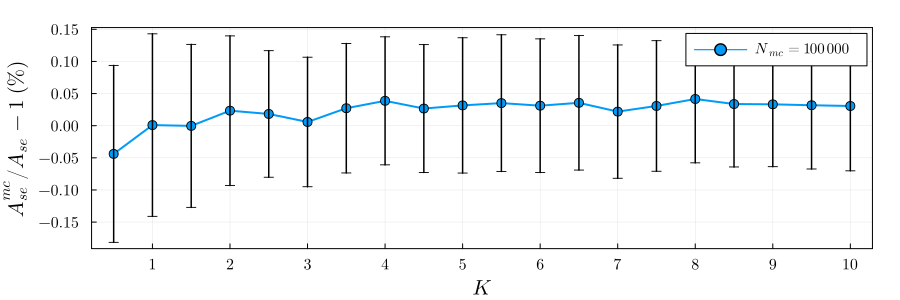

In [56]:
plot2 = plot(0.5:0.5:10,
               relative_Nmc100K,
               label =  L"$N_{mc}=100\,000$",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.90),
               size = (900, 300),
               ylabel = L"A_{se}^{mc}/A_{se} -1  \ (\%)",
               xlabel = L"K",
               yerror= error_relative_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm
               )

# title!(plot2, "Monte Carlo error compared with exact amplitude")
# savefig(plot2,"./plots/BF/self_energy/with_error_bars.svg")
# savefig(plot2,"./plots/BF/self_energy/with_error_bars.pdf")

@show plot2

In [91]:
#run(`convert -density 300 -trim ./plots/BF/self_energy/with_error_bars.svg -quality 100 ./plots/BF/self_energy/with_error_bars.eps`)

Process(`convert -density 300 -trim ./plots/BF/self_energy/with_error_bars.svg -quality 100 ./plots/BF/self_energy/with_error_bars.eps`, ProcessExited(0))

Even in loglog scale the exact and the MC are the one on top of the other

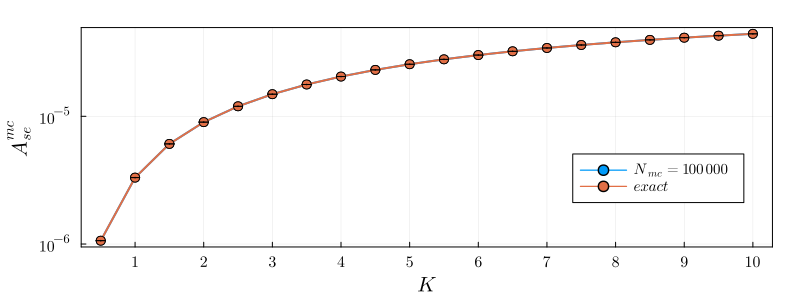

In [22]:
plot3 = plot(0.5:0.5:10,
               [amplitude_Nmc100K, exact_amplitude],
               #label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  [L"$N_{mc}=100\,000$" L"exact"],
               #title = ["Comparison with exact"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.35),
               ylabel = L"A_{se}^{mc}",
               xlabel = L"K",
               yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               margin=5Plots.mm
               )

# Extrapolating the layers

In [9]:
function extrapolate(aDL,aDLm1,aDLm2)
    num = aDL * aDLm2 - aDLm1^2 
    den = aDL  - 2* aDLm1 + aDLm2
    num/den
end

extrapolate (generic function with 1 method)

In [100]:
layers_trials_DL10 = DataFrame()
for trial in 1:20
    layers_trials_DL10[!,"$(trial)"]=[get_data(100000,10, trial).amp[id] - get_data(100000,10, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL9 = DataFrame()
for trial in 1:20
    layers_trials_DL9[!,"$(trial)"]=[get_data(100000,9, trial).amp[id] - get_data(100000,9, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL8 = DataFrame()
for trial in 1:20
    layers_trials_DL8[!,"$(trial)"]=[get_data(100000,8, trial).amp[id] - get_data(100000,8, trial).amp[id-1] for id in 2:21]
end

# Extrapolate 

layers_trials_extrapolation = DataFrame()
for trial in 1:20
    layers_trials_extrapolation[!,"$(trial)"]= extrapolate.(layers_trials_DL10[!,"$(trial)"],layers_trials_DL9[!,"$(trial)"],layers_trials_DL8[!,"$(trial)"])
end

In [101]:

layers_average_extrapolation =  [mean(row) for row in eachrow(layers_trials_extrapolation)];
layers_variance_extrapolation =  [var(row) for row in eachrow(layers_trials_extrapolation)];
amplitude_Nmc100K_extrapolation = [sum(layers_average_extrapolation[1:id]) for id in 1:20];
error_Nmc100K_extrapolation = sqrt.([sum(layers_variance_extrapolation[1:id]) for id in 1:20]);


relative_errors_Nmc100K_extrapolation = 100 .*error_Nmc100K_extrapolation./amplitude_Nmc100K_extrapolation;

## TEMPORARY CELL

In the following cell I extrapolate with to the old equation and *alla cazzo di cane*.

I just consider one trial (I'm lazy), extrapolating both the exact amplitude and the MC one.

In the fit, the exponent is equal to $1$ with an error of about $0.018$

In [116]:
exact_amplitude_8 = get_self_energy_exact(8).amp[2:end];
exact_amplitude_9 = get_self_energy_exact(9).amp[2:end];
exact_amplitude_10 = get_self_energy_exact(10).amp[2:end];

mc_amplitude_8 = Matrix(DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(100000)/EPRL/immirzi_0.1/Dl_$(8)/weight_1.0/ib_0/ampls_cutoff_10_trial_$(1).csv",
        ),
        ))[2:end,1]

mc_amplitude_9 = Matrix(DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(100000)/EPRL/immirzi_0.1/Dl_$(9)/weight_1.0/ib_0/ampls_cutoff_10_trial_$(1).csv",
        ),
    ))[2:end,1]

mc_amplitude_10 = Matrix(DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(100000)/EPRL/immirzi_0.1/Dl_$(10)/weight_1.0/ib_0/ampls_cutoff_10_trial_$(1).csv",
        ),
    ))[2:end,1]

exact_num = exact_amplitude_10 .* exact_amplitude_8 .- exact_amplitude_9.^2 
exact_den = exact_amplitude_10 .- 2 .* exact_amplitude_9 .+ exact_amplitude_8

mc_num = mc_amplitude_10 .* mc_amplitude_8 .- mc_amplitude_9.^2 
mc_den = mc_amplitude_10 .- 2 .* mc_amplitude_9 .+ mc_amplitude_8

exact_extrap = zeros(20)
mc_extrap = zeros(20)

for k=1:20
exact_extrap[k] = num[k]/den[k] 
mc_extrap[k] = mc_num[k]/mc_den[k] 
end

In [110]:
exact_extrap[:]

20-element Vector{Float64}:
 1.0901759030542612e-6
 3.4526168115878204e-6
 6.4665067190885685e-6
 9.781897052828487e-6
 1.3320402605374745e-5
 1.6977853570634916e-5
 2.0735554361922795e-5
 2.4550480686220574e-5
 2.84190482619409e-5
 3.2320912398732964e-5
 3.625746505469011e-5
 4.021840726433301e-5
 4.4206809173423656e-5
 4.8217295021579977e-5
 5.225337685541357e-5
 5.631226388053314e-5
 6.039743020928262e-5
 6.450751472479473e-5
 6.864577829255028e-5
 7.281168446273816e-5

In [109]:
mc_extrap

20-element Vector{Float64}:
 1.0907244184661786e-6
 3.4463192794549665e-6
 6.464551625676011e-6
 9.77886830352099e-6
 1.3325727692008773e-5
 1.698032152410687e-5
 2.0754443231336716e-5
 2.4575180404617515e-5
 2.843921439849401e-5
 3.233376372107114e-5
 3.62725141686139e-5
 4.022385588768045e-5
 4.4215461850852744e-5
 4.823103410300487e-5
 5.228958777109964e-5
 5.632497278350076e-5
 6.041344170797646e-5
 6.452382868516441e-5
 6.858282827868026e-5
 7.274114976063385e-5

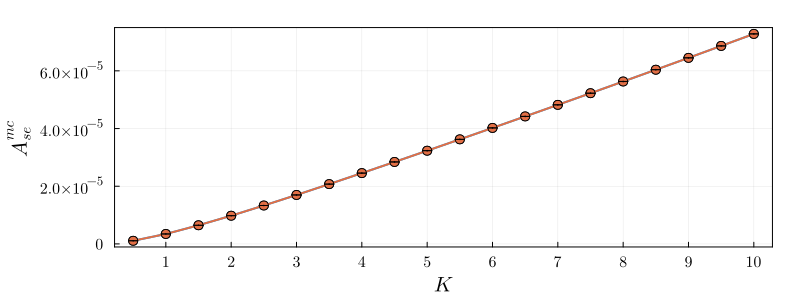

In [112]:
plot4 = plot(0.5:0.5:10,
               [exact_extrap, exact_extrap],
               #label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  "",
               #title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.35),
               ylabel = L"A_{se}^{mc}",
               xlabel = L"K",
               yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               margin=5Plots.mm
               )

# Fitting the amplitude to find the scaling

We fit the amplitude as a function of the cutoff K using least squares fit. We use as a model the function 
$$ c_2K^{c_1} +  c_3 K^{c_1-1}$$
and we perform the fit using only the last 10-ish points.

In [113]:
using LsqFit

In [114]:
@. model(K, c) = c[2] * K^c[1] + c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], exact_extrap[10:end], c0)
fit.param

4-element Vector{Float64}:
  1.9769483193225932
  6.655024720317088e-8
  7.670208551093285e-6
 -6.2376418165184564e-6

The error is computed automatically by the library. We use the 95% CI.

In [115]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.01841528519926037
 1.3803961707590967e-8
 2.651535471687909e-7
 4.689849859284482e-7

Visual check that the amplitude is compatible with the fit even with a bad fit!

In [17]:
function get_data_mu76(Nmc,Dl,trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/EPRL/immirzi_0.1/Dl_$(Dl)/weight_1.167/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end


get_data_mu76 (generic function with 1 method)

In [18]:
layers_trials_DL10_mu76 = DataFrame()
for trial in 1:20
    layers_trials_DL10_mu76[!,"$(trial)"]=[get_data_mu76(100000,10, trial).amp[id] - get_data_mu76(100000,10, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL9_mu76 = DataFrame()
for trial in 1:20
    layers_trials_DL9_mu76[!,"$(trial)"]=[get_data_mu76(100000,9, trial).amp[id] - get_data_mu76(100000,9, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL8_mu76 = DataFrame()
for trial in 1:20
    layers_trials_DL8_mu76[!,"$(trial)"]=[get_data_mu76(100000,8, trial).amp[id] - get_data_mu76(100000,8, trial).amp[id-1] for id in 2:21]
end

# Extrapolate 

layers_trials_extrapolation_mu76 = DataFrame()
for trial in 1:20
    layers_trials_extrapolation_mu76[!,"$(trial)"]= extrapolate.(layers_trials_DL10_mu76[!,"$(trial)"],layers_trials_DL9_mu76[!,"$(trial)"],layers_trials_DL8_mu76[!,"$(trial)"])
end

In [25]:
layers_average_extrapolation_mu86 =  [mean(row) for row in eachrow(layers_trials_extrapolation_mu86)];
layers_variance_extrapolation_mu86 =  [var(row) for row in eachrow(layers_trials_extrapolation_mu86)];
amplitude_Nmc100K_extrapolation_mu86 = [sum(layers_average_extrapolation_mu86[1:id]) for id in 1:20];
error_Nmc100K_extrapolation_mu86 = sqrt.([sum(layers_variance_extrapolation_mu86[1:id]) for id in 1:20]);

In [26]:
@. model(K, c) = c[2] * K^c[1] + c[3] * K^(c[1]-1)
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu86[10:end], c0)
fit.param

3-element Vector{Float64}:
 3.823347793541121
 4.84056159595963e-7
 3.776758526970601e-6

In [28]:
margin_error(fit, 0.05)

3-element Vector{Float64}:
 51.98281692012766
  0.00010229356780168796
  8.544463665184926e-6

In [23]:
function get_data_mu86(Nmc,Dl,trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/EPRL/immirzi_0.1/Dl_$(Dl)/weight_1.333/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end


get_data_mu86 (generic function with 1 method)

In [24]:
layers_trials_DL10_mu86 = DataFrame()
for trial in 1:20
    layers_trials_DL10_mu86[!,"$(trial)"]=[get_data_mu86(100000,10, trial).amp[id] - get_data_mu86(100000,10, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL9_mu86 = DataFrame()
for trial in 1:20
    layers_trials_DL9_mu86[!,"$(trial)"]=[get_data_mu86(100000,9, trial).amp[id] - get_data_mu86(100000,9, trial).amp[id-1] for id in 2:21]
end

layers_trials_DL8_mu86 = DataFrame()
for trial in 1:20
    layers_trials_DL8_mu86[!,"$(trial)"]=[get_data_mu86(100000,8, trial).amp[id] - get_data_mu86(100000,8, trial).amp[id-1] for id in 2:21]
end

# Extrapolate 

layers_trials_extrapolation_mu86 = DataFrame()
for trial in 1:20
    layers_trials_extrapolation_mu86[!,"$(trial)"]= extrapolate.(layers_trials_DL10_mu86[!,"$(trial)"],layers_trials_DL9_mu86[!,"$(trial)"],layers_trials_DL8_mu86[!,"$(trial)"])
end

In [25]:
layers_average_extrapolation_mu86 =  [mean(row) for row in eachrow(layers_trials_extrapolation_mu86)];
layers_variance_extrapolation_mu86 =  [var(row) for row in eachrow(layers_trials_extrapolation_mu86)];
amplitude_Nmc100K_extrapolation_mu86 = [sum(layers_average_extrapolation_mu86[1:id]) for id in 1:20];
error_Nmc100K_extrapolation_mu86 = sqrt.([sum(layers_variance_extrapolation_mu86[1:id]) for id in 1:20]);

In [26]:
@. model(K, c) = c[2] * K^c[1] + c[3] * K^(c[1]-1)
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_extrapolation_mu86[10:end], c0)
fit.param

3-element Vector{Float64}:
 3.823347793541121
 4.84056159595963e-7
 3.776758526970601e-6

In [28]:
margin_error(fit, 0.05)

3-element Vector{Float64}:
 51.98281692012766
  0.00010229356780168796
  8.544463665184926e-6

# Test 

In [56]:
@. model(K, c) = c[1] * K^2 + c[2] * K + c[3]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_extrapolation[10:end], c0)
fit.param

3-element Vector{Float64}:
 5.635299844081253e-7
 1.710298450889304e-6
 1.0481994125912519e-5

In [57]:
margin_error(fit, 0.05)


3-element Vector{Float64}:
 9.361521702776856e-8
 1.4103001172039587e-6
 5.1306135485517734e-6

In [58]:
@. model(K, c) = c[1] * K + c[2]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_extrapolation[10:end], c0)
fit.param

2-element Vector{Float64}:
  1.0163248217021641e-5
 -1.980774253610435e-5

In [59]:
margin_error(fit, 0.05)

2-element Vector{Float64}:
 6.055766057377456e-7
 4.641656788608986e-6